# CS247 Anime Recommendation Engine - Graph Embedding

This notebook serves as project for CS247 Advanced Data Mining.

Group member:
* Yiming Shi 905525611
* Penghai Wei 105726519
* Yongqian Li 004997466
* Yanxun Li 005712570

In this notebook we will build a recomender system using dataset **Anime Recommendation Database 2020**.

The notebook contains the following serveral sections:
* Input Processing
* Baseline Construction
* User Embedding based on Pointwise Mutual Information and Word2Vec

# Input Processing

In this section, we mainly extract the basic input from "animelist.csv". We cleaned the data, remove duplicate data, normalized the score value, and present an overview of the rating matrix.

In [ ]:
import numpy as np
import pandas as pd

import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import torch
import pickle

In [ ]:
from pathlib import Path
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
DATA_DIR = Path('/content/gdrive/MyDrive/CS247/Final_Project')
INPUT_DIR = '/content/gdrive/MyDrive/CS247/Final_Project'

In [ ]:
import gc
gc.collect()

162

In [ ]:
with open(DATA_DIR/'genre_embedding_map_small.pkl', 'rb') as f:
    genre_embedding_map = pickle.load(f)

In [ ]:
rating_df = pd.read_csv('/content/gdrive/MyDrive/CS247/Final_Project/data_new.csv',
                        #nrows=5000000,
                        low_memory=False, 
                        usecols=["user_id", "anime_id", "rating"]
                        )

## Baseline Model

In [ ]:
# Removing Duplicated Rows
duplicates = rating_df.duplicated()

if duplicates.sum() > 0:
    print('> {} duplicates'.format(duplicates.sum()))
    rating_df = rating_df[~duplicates]

print('> {} duplicates'.format(rating_df.duplicated().sum()))

> 0 duplicates


In [ ]:
# Quick review of our rating matrix
g = rating_df.groupby('user_id')['rating'].count()
top_users = g.dropna().sort_values(ascending=False)[:20]
top_r = rating_df.join(top_users, rsuffix='_r', how='inner', on='user_id')

g = rating_df.groupby('anime_id')['rating'].count()
top_animes = g.dropna().sort_values(ascending=False)[:20]
top_r = top_r.join(top_animes, rsuffix='_r', how='inner', on='anime_id')

pd.crosstab(top_r.user_id, top_r.anime_id, top_r.rating, aggfunc=np.sum)


# Generate Training and testing data.

# Encoding categorical data
user_ids = rating_df["user_id"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded2user = {i: x for i, x in enumerate(user_ids)}
rating_df["user"] = rating_df["user_id"].map(user2user_encoded)
n_users = len(user2user_encoded)

anime_ids = rating_df["anime_id"].unique().tolist()
anime2anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded2anime = {i: x for i, x in enumerate(anime_ids)}
rating_df["anime"] = rating_df["anime_id"].map(anime2anime_encoded)
n_animes = len(anime2anime_encoded)

print("Num of users: {}, Num of animes: {}".format(n_users, n_animes))
print("Min rating: {}, Max rating: {}".format(min(rating_df['rating']), max(rating_df['rating'])))







X = rating_df[['user', 'anime']].values
y = rating_df["rating"]






# Split
test_set_size = 1000 #1k for test set
train_indices = rating_df.shape[0] - test_set_size 
test_indicies = rating_df.shape[0] - test_set_size 

X_train, X_test, y_train, y_test = (
    X[:train_indices],
    X[test_indicies:],
    y[:train_indices],
    y[test_indicies:],
)

print('> Train set ratings: {}'.format(len(y_train)))
print('> Test set ratings: {}'.format(len(y_test)))





# set the training and testing array
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]





# Setup TPU
import tensorflow as tf

TPU_INIT = False

if TPU_INIT:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    !nvidia-smi
    
print(tf.__version__)

Num of users: 7826, Num of animes: 15828
Min rating: 0.0, Max rating: 1.0
> Train set ratings: 4708362
> Test set ratings: 1000
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

2.8.0


In [ ]:
import keras
from keras import layers 
import tensorflow as tf
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.layers import Add, Activation, Lambda, BatchNormalization, Concatenate, Dropout, Input, Embedding, Dot, Reshape, Dense, Flatten

def BaselineNet():
    embedding_size = 128
    
    user = Input(name = 'user', shape = [1])
    user_embedding = Embedding(name = 'user_embedding',
                       input_dim = n_users, 
                       output_dim = embedding_size)(user)
    
    anime = Input(name = 'anime', shape = [1])
    anime_embedding = Embedding(name = 'anime_embedding',
                       input_dim = n_animes, 
                       output_dim = embedding_size)(anime)
    
    x = Dot(name = 'dot_product', normalize = True, axes = 2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(loss='binary_crossentropy', metrics=["mae", "mse"], optimizer='Adam')
    
    return model

if TPU_INIT:    
    with tpu_strategy.scope():
        model = BaselineNet()
else:
    model = BaselineNet()

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user (InputLayer)              [(None, 1)]          0           []                               
                                                                                                  
 anime (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 user_embedding (Embedding)     (None, 1, 128)       1001728     ['user[0][0]']                   
                                                                                                  
 anime_embedding (Embedding)    (None, 1, 128)       2025984     ['anime[0][0]']                  
                                                                                              

In [ ]:
# Callbacks
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

if TPU_INIT:
    max_lr = max_lr * tpu_strategy.num_replicas_in_sync
    batch_size = batch_size * tpu_strategy.num_replicas_in_sync

rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

checkpoint_filepath = './weights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        save_best_only=True)

early_stopping = EarlyStopping(patience = 3, monitor='val_loss', 
                               mode='min', restore_best_weights=True)

my_callbacks = [
    model_checkpoints,
    lr_callback,
    #early_stopping,   
]

In [ ]:
# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/20
471/471 [==============================] - 24s 49ms/step - loss: 0.7511 - mae: 0.3158 - mse: 0.1397 - val_loss: 0.7046 - val_mae: 0.2984 - val_mse: 0.1197 - lr: 1.0000e-05
Epoch 2/20
471/471 [==============================] - 24s 52ms/step - loss: 0.7475 - mae: 0.3140 - mse: 0.1382 - val_loss: 0.7460 - val_mae: 0.3141 - val_mse: 0.1374 - lr: 1.8000e-05
Epoch 3/20
471/471 [==============================] - 21s 44ms/step - loss: 0.7416 - mae: 0.3111 - mse: 0.1357 - val_loss: 0.7444 - val_mae: 0.3130 - val_mse: 0.1368 - lr: 2.6000e-05
Epoch 4/20
471/471 [==============================] - 25s 53ms/step - loss: 0.7337 - mae: 0.3070 - mse: 0.1323 - val_loss: 0.7394 - val_mae: 0.3105 - val_mse: 0.1347 - lr: 3.4000e-05
Epoch 5/20
471/471 [==============================] - 21s 45ms/step - loss: 0.7233 - mae: 0.3015 - mse: 0.1278 - val_loss: 0.7319 - val_mae: 0.3063 - val_mse: 0.1314 - lr: 4.2000e-05
Epoch 6/20
471/471 [==============================] - 21s 44ms/step - loss: 0.7090 - 

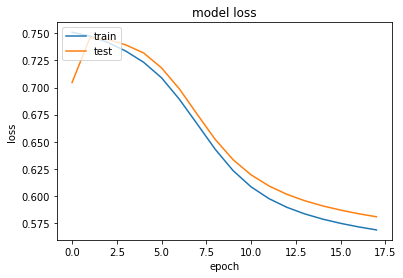

In [ ]:
#Training results
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history["loss"][0:-2])
plt.plot(history.history["val_loss"][0:-2])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

# Graph Embedding on User

## Generating User embeddings


In [ ]:
# Visualize the dataset
rating_df.head()

,user_id,anime_id,rating,user,anime
0,259419,30187,0.9,0,0
1,36365,32946,0.3,1,1
2,141167,21995,0.5,2,2
3,350981,139,0.0,3,3
4,325260,27899,0.7,4,4


We currently choose to define ratings $\geq 0.8$ as high ratings. This threshold can change.

In [ ]:
# High ratings threshold
min_rating = 0.8

pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.

high_rating = (rating_df)[rating_df.rating >= min_rating]
# Use the following line instead if the computational resources are relatively limited
#high_rating = (rating_df.sample(1000000))[rating_df.rating >= min_rating]


In [ ]:
min_rating = 0.8
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
high_rating = (rating_df)[rating_df.rating >= min_rating]

len(high_rating)




1388667

In [ ]:
gc.collect()

5410

In [ ]:
#pair_frequency = np.zeros([n_users, n_users]) # to ensure all users are included in the embedding generation

#Step 1: create the weighted edges between animes.
#min_rating = 5

pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
#rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
#animes_grouped_by_users = list(rating_df.groupby("user_id"))
users_grouped_by_animes = list(high_rating.groupby("anime"))
for group in tqdm(
    users_grouped_by_animes,
    position=0,
    leave=True,
    desc="Compute rating frequencies",
):
    # Get a list
    #current_animes = list(group[1]["anime_id"])
    current_users = list(group[1]["user"])

    for i in range(len(current_users)):
        item_frequency[current_users[i]] += 1
        for j in range(i + 1, len(current_users)):
            x = min(current_users[i], current_users[j])
            y = max(current_users[i], current_users[j])
            pair_frequency[(x, y)] += 1

Compute rating frequencies: 100%|██████████| 13924/13924 [13:15<00:00, 17.49it/s]  


In [ ]:
#high_rating_subset.head()
#pair_frequency[0:5]

In [ ]:
#max(rating_df["user"])
#idx_pairs_list = [] # to ensure all users are included in the embedding generation
#for i in range(n_users):
  #idx_pairs_list += [(i,j) for j in range(i + 1, n_users)]

In [ ]:
# Group instances by user.
#animes_grouped_by_users = list(high_rating.groupby("user"))
#num_users = len(animes_grouped_by_users)

In [ ]:
f = open("/content/gdrive/MyDrive/CS247/Final_Project/pair_frequency.pkl","wb")
pickle.dump(pair_frequency,f)
f.close()

In [ ]:
#from tqdm import tqdm
#import pickle

with open('pair_frequency.pkl', 'rb') as f: 
    pair_frequency = pickle.load(f)

In [ ]:
#users_grouped_by_animes[1][1]
n_users

7826

In [ ]:
D = math.log(sum(item_frequency.values()))
D

14.143854852173321

In [ ]:
min_weight = 150 #10 subject to change
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
#animes_graph = nx.Graph()
users_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
#added_users_dic = {}

for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the users graph"
):

    x, y = pair
    
    xy_frequency = pair_frequency[x, y]#pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]

    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        #animes_graph.add_edge(x, y, weight=weight)
        users_graph.add_edge(x, y, weight=weight)
    #else:
    #    users_graph.add_node(x) # to ensure all users are included in the embedding generation


print("Total number of graph nodes:", users_graph.number_of_nodes())

for user in tqdm(
    range(n_users), position=0, leave=True, desc="Adding nodes(users) with no edges"
):
    if user not in users_graph:
      users_graph.add_node(user) # to ensure all users are included in the embedding generation


Creating the users graph: 100%|██████████| 26375039/26375039 [01:18<00:00, 335534.12it/s]


Total number of graph nodes: 6682


Adding nodes(users) with no edges: 100%|██████████| 7826/7826 [00:00<00:00, 998406.88it/s]


In [ ]:
print("Total number of graph nodes:", users_graph.number_of_nodes())
print("Total number of graph edges:", users_graph.number_of_edges())

Total number of graph nodes: 7826
Total number of graph edges: 6078493


In [ ]:
degrees = []
for node in users_graph.nodes:
    degrees.append(users_graph.degree[node])

print("Average node degree:", round(sum(degrees) / len(degrees), 2))

Average node degree: 1553.41


In [ ]:
vocabulary = ["NA"] + list(users_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

In [ ]:
vocabulary[0:5]

['NA', 0, 2836, 25, 7364]

In [ ]:
vocabulary_lookup[2836]

2

In [ ]:
def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
          try:
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)
          except:
            pass

    return walks

In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 5#10
walks = random_walk(users_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

Random walks iteration 3 of 5:  62%|██████▏   | 4880/7826 [07:48<05:11,  9.47it/s]

Random walks iteration 5 of 5: 100%|██████████| 7826/7826 [11:59<00:00, 10.87it/s]


Number of walks generated: 33410


Generating postive and negative examples: 100%|██████████| 33410/33410 [01:29<00:00, 372.30it/s]


Epoch 1/10
10247/10247 [==============================] - 92s 9ms/step - loss: 0.9600
Epoch 2/10
10247/10247 [==============================] - 91s 9ms/step - loss: 0.9509
Epoch 3/10
10247/10247 [==============================] - 92s 9ms/step - loss: 0.9496
Epoch 4/10
10247/10247 [==============================] - 92s 9ms/step - loss: 0.9478
Epoch 5/10
10247/10247 [==============================] - 92s 9ms/step - loss: 0.9454
Epoch 6/10
10247/10247 [==============================] - 91s 9ms/step - loss: 0.9427
Epoch 7/10
10247/10247 [==============================] - 91s 9ms/step - loss: 0.9402
Epoch 8/10
10247/10247 [==============================] - 91s 9ms/step - loss: 0.9383
Epoch 9/10
10247/10247 [==============================] - 91s 9ms/step - loss: 0.9368
Epoch 10/10
10247/10247 [==============================] - 92s 9ms/step - loss: 0.9358


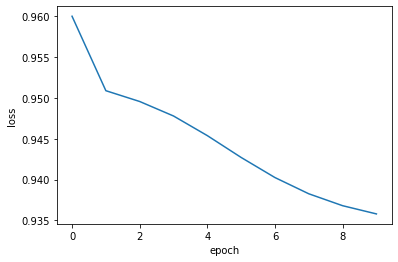

Embeddings shape: (7827, 128)


In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(users_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))


def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)


batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

learning_rate = 0.001#0.001
embedding_dim = 128#50
num_epochs = 10

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="user_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


model_node2vec = create_model(len(vocabulary), embedding_dim)
model_node2vec.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)
#model_node2vec.summary()


history = model_node2vec.fit(dataset, epochs=num_epochs)



plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()



users_embeddings = model_node2vec.get_layer("user_embeddings").get_weights()[0]
print("Embeddings shape:", users_embeddings.shape)




f3 = open("/content/gdrive/MyDrive/CS247/Final_Project/user_embeddings_n2v_weight10_w10_s10.pkl","wb")
pickle.dump(users_embeddings,f3)
f3.close()

f6 = open("/content/gdrive/MyDrive/CS247/Final_Project/vocabulary.pkl","wb")
pickle.dump(vocabulary,f6)
f6.close()

f7 = open("/content/gdrive/MyDrive/CS247/Final_Project/vocabulary_lookup.pkl","wb")
pickle.dump(vocabulary_lookup,f7)
f7.close()

In [ ]:
f8 = open("/content/gdrive/MyDrive/CS247/Final_Project/rating_df_current.pkl","wb")
pickle.dump(rating_df,f8)
f8.close()

f9 = open("/content/gdrive/MyDrive/CS247/Final_Project/high_rating.pkl","wb")
pickle.dump(high_rating,f9)
f9.close()

In [ ]:

f2 = open("users_walks_small.pkl","wb")
pickle.dump(walks,f2)
f2.close()


In [ ]:
with open('users_walks_small.pkl', 'rb') as f2: 
    walks = pickle.load(f2)

In [ ]:
f3 = open("/content/gdrive/MyDrive/CS247/Final_Project/user_embeddings_n2v_weight10_w10_s10.pkl","rb")
users_embeddings = pickle.load(f3)
f3.close()

f6 = open("/content/gdrive/MyDrive/CS247/Final_Project/vocabulary.pkl","rb")
vocabulary = pickle.load(f6)
f6.close()

f7 = open("/content/gdrive/MyDrive/CS247/Final_Project/vocabulary_lookup.pkl","rb")
vocabulary_lookup = pickle.load(f7)
f7.close()

EOFError: ignored

In [ ]:
def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating postive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

Generating postive and negative examples: 100%|██████████| 37182/37182 [00:21<00:00, 1769.42it/s]


In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

In [ ]:
learning_rate = 0.001#0.001
embedding_dim = 128#50
num_epochs = 10

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="user_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [ ]:
model_node2vec = create_model(len(vocabulary), embedding_dim)
model_node2vec.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)
model_node2vec.summary()


In [ ]:
history = model_node2vec.fit(dataset, epochs=num_epochs)

Epoch 1/10
3105/3105 [==============================] - 38s 12ms/step - loss: 0.8120
Epoch 2/10
3105/3105 [==============================] - 39s 13ms/step - loss: 0.8050
Epoch 3/10
3105/3105 [==============================] - 39s 12ms/step - loss: 0.7818
Epoch 4/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.7520
Epoch 5/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.7257
Epoch 6/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.7057
Epoch 7/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.6911
Epoch 8/10
3105/3105 [==============================] - 38s 12ms/step - loss: 0.6804
Epoch 9/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.6726
Epoch 10/10
3105/3105 [==============================] - 37s 12ms/step - loss: 0.6667


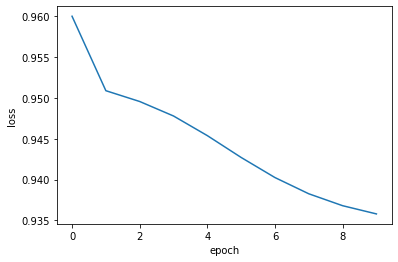

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Analyzing the embeddings

In [ ]:
users_embeddings = model_node2vec.get_layer("user_embeddings").get_weights()[0]
print("Embeddings shape:", users_embeddings.shape)

Embeddings shape: (7827, 128)


In [ ]:
f3 = open("user_embeddings_n2v_0.8_weight150_w10_s10.pkl","wb")
pickle.dump(users_embeddings,f3)
f3.close()

In [ ]:
df = pd.read_csv(INPUT_DIR + '/anime.csv', low_memory=True)
df = df.replace("Unknown", np.nan)

In [ ]:
# Fixing Names
def getAnimeName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
    except:
        print('error')
    
    return name

df['anime_id'] = df['MAL_ID']
df["eng_version"] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: getAnimeName(x))

df.sort_values(by=['Score'], 
               inplace=True,
               ascending=False, 
               kind='quicksort',
               na_position='last')

df = df[["anime_id", "eng_version", 
         "Score", "Episodes", 
         "Type", "Premiered", "Members"]]

In [ ]:
#users_embedding_NA = users_embeddings[0]
#users_embeddings = users_embeddings[1:]
#print("Embeddings shape:", users_embeddings.shape)

Embeddings shape: (7827, 128)


In [ ]:
random_user = random.choice(range(len(users_embeddings)))
print("Random user: ", random_user)

Random user:  3728


In [ ]:
ratings_per_user = rating_df.groupby('user').size()
random_user = ratings_per_user[ratings_per_user < 500].sample(1, random_state=None).index[0]
print('> user_id:', random_user)

> user_id: 1716


In [ ]:
#random_user = 1067#934
#random_user = 7435
random_usr_idx_in_emb = vocabulary_lookup[random_user]

target = np.expand_dims(users_embeddings[random_usr_idx_in_emb], axis=0)
#target.shape
#similarities = #np.multiply(target, users_embeddings)
similarities = target * users_embeddings 

# Calculate cosine simiarities:
similarities = np.sum(similarities, axis=1) / (np.linalg.norm(users_embeddings, axis=1) * np.linalg.norm(target, axis=1))
#similarities.shape
similar_users = np.argsort(similarities)
similar_users = similar_users[::-1]

# random_user should have similarity 1.0
for simuser_idx_emb in similar_users[0:11]:
    print("Similar user:", vocabulary[simuser_idx_emb], "     similarity:", similarities[simuser_idx_emb])

Similar user: 1716      similarity: 1.0
Similar user: 7332      similarity: 0.37617427
Similar user: 5284      similarity: 0.3572869
Similar user: 4215      similarity: 0.33717933
Similar user: 1542      similarity: 0.32325098
Similar user: 3545      similarity: 0.31841034
Similar user: 156      similarity: 0.3134742
Similar user: 6885      similarity: 0.30966923
Similar user: 502      similarity: 0.30908826
Similar user: 4237      similarity: 0.2984705
Similar user: 6061      similarity: 0.28957886


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
random_user_id = user_encoded2user[random_user]

def get_user_preferences(user_id, plot=False, verbose=0):
    animes_watched_by_user = rating_df[rating_df.user_id==user_id]
    #user_rating_percentile = np.percentile(animes_watched_by_user.rating, 75)
    #animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating >= user_rating_percentile]
    top_animes_user = (
        animes_watched_by_user.sort_values(by="rating", ascending=False)#.head(10)
        .anime_id.values
    )
    
    anime_df_rows = df[df["anime_id"].isin(top_animes_user)]
    anime_df_rows = anime_df_rows[["eng_version"]]
    
    if verbose != 0:
        print("> User #{} has rated {} movies (avg. rating = {:.1f})".format(
          user_id, len(animes_watched_by_user),
          animes_watched_by_user['rating'].mean(),
        ))
    
        print('> preferred genres')
    
#     if plot:
#         getFavGenre(anime_df_rows, plot)
        
    return anime_df_rows#.eng_version.values

user_pref = get_user_preferences(random_user_id, plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(15)

> User #70437 has rated 404 movies (avg. rating = 0.5)
> preferred genres
> animes highly rated by this user


,eng_version
3971,Fullmetal Alchemist:Brotherhood
9913,Gintama Season 4
6006,Gintama Season 2
7261,Gintama:Enchousen
12898,March Comes In Like A Lion 2nd Season
12242,Gintama Season 5
14293,Gintama.:Silver Soul Arc - Second Half War
13901,Gintama.:Silver Soul Arc
12500,Made in Abyss
1431,Code Geass:Lelouch of the Rebellion


In [ ]:
user_pref = get_user_preferences(user_encoded2user[5284], plot=True, verbose=1)
print('> animes highly rated by this user')

pd.DataFrame(user_pref).head(15)

> User #210237 has rated 521 movies (avg. rating = 0.6)
> preferred genres
> animes highly rated by this user


,eng_version
11308,Your Name.
0,Cowboy Bebop
8559,MUSHI-SHI -Next Passage-
1431,Code Geass:Lelouch of the Rebellion
142,Princess Mononoke
404,Howl's Moving Castle
6607,Fate/Zero Season 2
8430,The Shadow that Devours the Sun
8305,Haikyu!!
11,One Piece


In [ ]:
# Saving the embeddings in a useable format
users_n2vembeddings_map = {}
for user in range(n_users):
  users_n2vembeddings_map[user_encoded2user[user]] = users_embeddings[vocabulary_lookup[user]]

f5 = open("users_n2vembeddings_map.pkl","wb")
pickle.dump(users_n2vembeddings_map,f5)
f5.close()

In [ ]:
# load users embeddings

del users_n2vembeddings_map
with open('users_n2vembeddings_map(full).pkl', 'rb') as f5:
  users_n2vembeddings_map = pickle.load(f5)

for user_id in users_n2vembeddings_map:
  user = user2user_encoded[user_id]
  users_embeddings[vocabulary_lookup[user]] = users_n2vembeddings_map[user_id]